# Project 1: Advanced Preparation of Financial Data Pipeline 2
Understanding pricing strategies in the context of the Initial Public Offering (IPO) process has been receiving much attention. Most prior studies have however focused on information sources from post issuance periods, and understanding such strategies from the management’s perspective during the IPO process is still an open research issue. Form 424 variants, as finalized IPO prospectus approved by Security Exchange Committee (SEC), contain rich and genuine information about the issuing firms. In this study, we analyze the inter-relationships between the management’s confidence (through the proxy of sentiments expressed in textual contents in the Management’s Discussion & Analysis (MD&A) sections in the prospectus) and the pre-/post-IPO valuations.

![image.png](data_dictionary.jpeg)

The data used for this project includes successful U.S. IPOs from more than 600 companies. Our "client" is interested in which features are most important to the "underpricing" phenomenon most commenly seen in the stock market. By using advanced and novel methods to prepare the collected IPO data, we will break down the data in order to process it through phases of a CRISP-DM model. Through this project our team experimented with many different pipelines and methods. We would like to briefly outline 2 pipelines that produced the best results. 

In this tutorial we will be following the 2nd pipeline. The other two pipelines are in the same repository for you to see. 

Our project pipeline number 1 is as follows:
- Descriptive
- Imputation
- Feature engeneering (Calcuation)
- Normalization  
- Outlier Detection (3-standard deviations)
- Standardization (z-score, scaler...)
- Correlation analysis
- Recoding (one-hot encoding, binning)
- Feature Selection

Our project pipeline number 2 is as follows:
- Descriptive
- Imputation
- Feature engeneering (Calcuation)
- Outlier Detection (IQR)
- Standardization (min-max)
- Normalization
- Correlation analysis 
- Recoding (encoding, binning)
- Feature selection
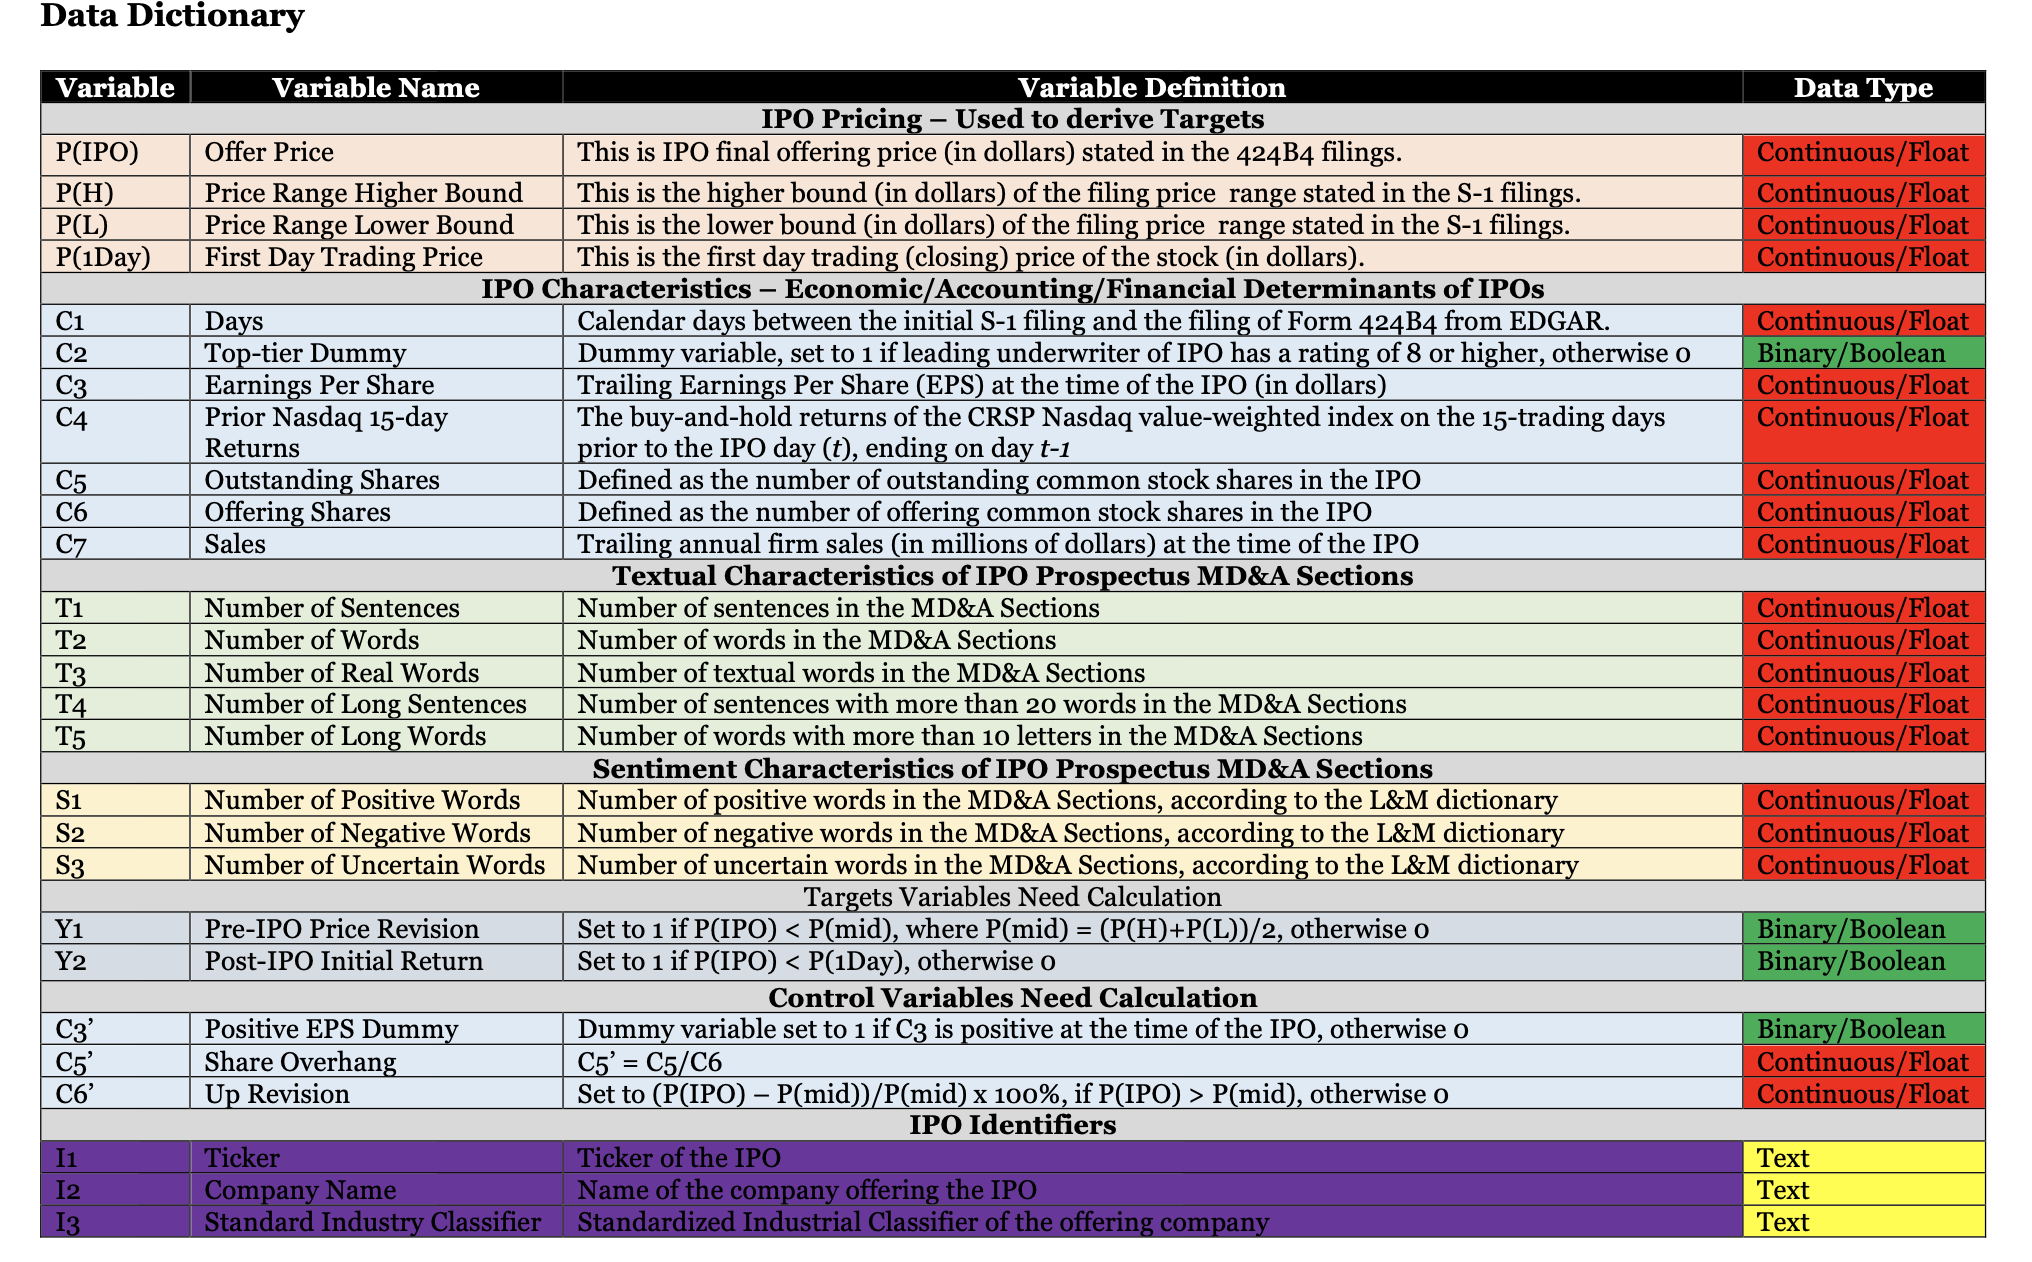

In [ ]:
# import required libraries 
import pandas as pd
import numpy as np

## Data assumptions

**IPO characteristics (C columns)** can contain 0, less than 0 values but no strings<br>
That is because finance/accounting determinants can be 0 or be negative (e.g. EPS, sales, can be negative and 0)<br>

**Sentiment characteristics (S columns)** can contain 0 values but cannot be less than 0 or have strings<br>
Our assumption is that you cannot have a negative amount of words (we only encountered 2). We decided we will allow 0 values here because there aren't many. Our reasoning this section to contain 0 values is becasue of the difficulty translating sentimental analysis for companies not in the US and lack of data. <br>

**Textual Characteristics (T3-T5 columns )** can contain 0 and less than 0 values but no strings, however, **T1 and T2** (Nbr of sentences, number of words respectively) cannot contain 0, less than 0, and no string values. Our assumption is the same that you simply cannot have a negative or zero amount of words. <br>

**IPO pricing (P columns)** cannot contain 0, less than 0, and string values <br>
This column cannot contain these values because we will use it to calculate the control and target variables. <br>
    
**Note:** These calculations will make P columns are called force predictors or price leakers, therefore, they will have to be removed because they will interfere with results (e.g. it can happen that you get 100% accuracy by including them which is unrealistic). 

In [ ]:
# read in the whole file and '-' as NA values, we figured that out by first reading in our data
data = pd.read_excel('Competition1_raw_data.xlsx', na_values=r'-')
# display first 5 rows 
data.head(5)

# Descriptive analysis
First descriptive statistics are a way to summarize a given set of data. They are used to give a quick snapshot of the data. Typically, descriptive statistics are broken down into measures of central tendency and measures of variability. Measures of central tendency would include mean, median, and mode, while measures of variability include standard deviation, variance, min/max values, and skewness. We used both methods of descriptive statistics in this project.
Descriptive statistics can also be used to decribe the number of overall records, the number of missing records, and any other information you think is useful for an outsider to understand the dataset.

We see there are missing values in all columns but I1 and I3. Moreover, some values that were supposed to be binary are floats.

In [ ]:
data.info()

With a quick scan we can identify the columns that should not contain zero or negative values. 

In [ ]:
data.describe()

## Imputation 
Unfortuantly, most data is not without missing values. As a result, imputation must be performed in order to replace those missing values with actual values. These missing values are typically seen as NaN in the dataset. It is important to remember that with imputation we will be introducing an error to our data. There are several imputation options, including: 
1. Forward fill, backward fill 
2. Regression
3. Implied imputation (Moving Average, stdev...) 
3. Decision trees, Naive Baise... 
4. Mean 
5. Median
6. Mode
7. Manual filling with online research
8. Dropping 

We did not use forward, backward fill, regression, and moving average methods as its not time-series and data is unique for each company which will introduce a lot of error to our data.  Decision trees or Naive Baise would be a viable alternative for imputation but due to time constraint and a low amount of errors we decided to proceed to impute NA values with constants (mean, median, mode). As a design decision, median is usually a preffered method of imputing missing values.  Median is generally considered to be the best representative of where the center of the data is. The more skewed the distribution, the greater the difference between the median and mean, and therefore, even more reason to use median instead of mean. However, some may argue that mean best represents the normal distribution of the data. Therefore, we will test both. The most accurate way would be to manually impute values with reseach, but it would be too labor intensive. You may also drop data that is missing from a dataset, however, this method is highly discouraged because you are loosing data. Moreover, you can benefit with imputation rather than just ignoring a variable. Many models still perform good with 20-35% of imputation. It really depends on scenario. In our case we must drop NA values for P columns as we use them to calculate the target features. 

Documentation for fillna methods can be found [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [ ]:
# replace with nan based on our conditions
data.loc[(data['S1'] < 0),'S1'] = np.nan
data.loc[(data['T2'] == 0),'T2'] = np.nan
data.loc[(data['T5'] < 0),'T5'] = np.nan
# replace T3, and T4
data.loc[(data['T3'] == 0),'T3'] = np.nan
data.loc[(data['T4'] == 0),'T4'] = np.nan

# impute with mean 
data['S1'] = data['S1'].fillna(data['S1'].median())
data['T2'] = data['T2'].fillna(data['T2'].median())
data['T5'] = data['T5'].fillna(data['T5'].median())
data['C3_impute'] = data['C3'].fillna(data['C3'].median())
data['C7_impute'] = data['C7'].fillna(data['C7'].median())
data['T3'] = data['T3'].fillna(data['T3'].median())
data['T4'] = data['T4'].fillna(data['T4'].median())

# drop NA values for P columns
data.dropna(subset=['P(IPO)', 'P(H)', 'P(L)', 'P(1Day)'], inplace=True)

# exclude C3 and C7 that were just imputed 
data = data.drop(['C3','C7'],axis=1)

In [ ]:
# quick look of our data now 
data.info()

In [ ]:
# sum of null values per column 
data.isnull().sum()

## Feature engeneering (Calculation)

We dicide to drop C6 prime as we discovered its a force predictor (e.g. we got 100% accuracy with it). Based on the calculation its too similar to our target variables. We also drop I1 and I2 as our main purpuse is improving the model accuracy and we did not find these text variables helpful, although it could be useful for viziulization. Moreover, we removed other force predictors which are the P columns that we used to calculate our target variables.  

Through this tutorial we show you different ways on generating new features for your model. 

Here a helful link on [feature engineering](https://towardsdatascience.com/feature-engineering-in-python-part-i-the-most-powerful-way-of-dealing-with-data-8e2447e7c69e).

In [ ]:
# Middle price between higher and lower point of IPO evaluation for which IPO is priced at 
# its purpuse is to create target variables (classification)
data['P(mid)'] = (data['P(H)'] + data['P(L)'])/2 # P(mid) = (P(H)+P(L))/2

# replace Y1 and change dtype to binary
data['Y1'] = np.where((data['P(IPO)'] < data['P(mid)']), 1, 0)
data['Y2'] = np.where((data['P(IPO)'] > data['P(1Day)']), 1, 0)

# another way to impute is with a function especially if you will reuse it 
# if value is bigger than zero return 1 else 0 
def c3_prime(c3_impute):
    if c3_impute > 0:
        return (1)
    else:
        return (0)

# Control variables calculation
# Apply the function above and create an new column 
data['C3`'] = data['C3_impute'].apply(c3_prime)
data['C3`'] = data['C3`'].astype(int) # convert to correct data type

# calculate share overhang C5`
data['C5`'] = data['C5']/data['C6']
data['C5`'] = data['C5`'].astype(float)

# calculate up revision C6`
# later on we will remove this column as its a force predictor e.g. it gaves us 100% accuracy
data['C6`'] = ((data['P(IPO)'] - data['P(mid)']) / data['P(mid)']) * 1
#data['C6`'] = 0
#data['C6`'] = np.where((data['P(IPO)'] > data['P(mid)']),data['C6`'],data['C6`'])
data['C6`'] = np.where((data['P(IPO)'] <= data['P(mid)']),0,data['C6`'])
#data['C6`'] = np.where((data['P(mid)']==0),0,data['C6`'])
data['C6`'] = data['C6`'].astype(float)
    
# C2 to correct data type (integer)
data['C2'] = data['C2'].astype(int)

# drop P columns that were only used for a calculation A.K.A leakers
data = data.drop(['P(mid)','P(IPO)', 'P(H)', 'P(L)', 'P(1Day)','I1','I2'],axis=1)

## Ratios
You should avoid using counts (T1-T5,S1-S3) but ratios for machine learning accuracy and efficiency. It is usually better to have a balanced training set, since otherwise the decision boundary is gonna give too much space to the bigger class and you are going to misclassify too much the small class. This is usually bad. Think of cancer detection where the smaller class is the most costly, namely having a tumor.

Here we create different ratios. You can mix and match all the ratios, HERE are a few different methods you can use.  

In [ ]:
#percent of long sentences
data["T1ratio"] = data["T4"].astype(float)/data["T1"].astype(float)
# T2
data['T2ratio'] = data['T5'].astype(float)/data['T2'].astype(float)
#percent of real words
data["T3ratio"] = data["T3"].astype(float)/data["T2"].astype(float)
#percent of long sentences
data["T4ratio"] = data["T1"].astype(float)/data["T4"].astype(float)
# percent of long words 
data["T5ratio"] = data["T2"].astype(float)/data["T1"].astype(float)
#percent of positive words
data["S1ratio"] = data["S1"].astype(float)/data["T2"].astype(float)
#percent of negative words
data["S2ratio"] = data["S2"].astype(float)/data["T2"].astype(float)
#percent of uncertain words
data["S3ratio"] = data["S3"].astype(float)/data["T2"].astype(float)

# drop the original S and T columns
data = data.drop(['S1','S2','S3','T1','T2','T3','T4','T5'],axis = 1)

In [ ]:
# looks good
# It not neccessary but note: ALWAYS put target variables to end columns to the right before running a model
data.info()

# Outlier Detection

Machine learning algorithms are very sensitive to the range and distribution of attribute values. Data outliers can spoil and mislead the training process resulting in longer training times, less accurate models and ultimately poorer results. There are many different statistical ways to identify outliers for example, box plots, scatter plots (only for continous dtype), z-score, IQR etc. 

The **Z-score** is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution. Well, while calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers. We used the same threshold. 

**Note:** By using z-score you are making an assumption that data is normal. Therefore, this method was used in our first pipeline where we first normalize our data. For the 2nd pipeline we used the IQR method. 

The **interquartile range (IQR)**, also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1. In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data. It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers. That is the reason we can only used it in the 2nd pipeline as IQR doesn't assume normal distribution. 

Other methods than we tried for both pipelines were enforcing upper and lower bound, binning, and doing nothing. When outliers you also have 3 options: 
- Impute (replace with lower, upper bound)
- Drop
- Ignore

Visit [here](https://medium.com/@prashant.nair2050/hands-on-outlier-detection-and-treatment-in-python-using-1-5-iqr-rule-f9ff1961a414) for more information.

### IQR method
Here we different ways of detecting and managing outliers with IQR. As we said we will use IQR lower and upper bound. Meaning values that are lower than 0.25 and bigger than 0.75 range will be replaced by it bound. 

In [ ]:
# import module
import matplotlib.pyplot as plt

In [ ]:
# make a copy
data1 = data.copy()
# remove categorical and target variables 
data1 = data1[['C1', 'C4', 'C5','C6', 'C3_impute', 'C7_impute', 'C5`','C6`',
       'T1ratio', 'T2ratio', 'T3ratio', 'T4ratio', 'T5ratio', 'S1ratio',
       'S2ratio', 'S3ratio']]

In [ ]:
# Calculate IQR range
Q1 = data1.quantile(0.25)
Q3 = data1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

### Number of outliers in columns
Easy way to see how many outliers we have in our data based on the IQR range. The most number of outliers reside in the Earnings per Share column (C3_impute) - 106, then offering shares (C6) - 72, number of days before F-1 filling (C1) - 67 etc.. IPO companies are unique with different sizes and revenues so, this outliers made sense. However, it would interfere with model learning. Feel free your own upper and lower boundry perhaps, you could get better results. 

In [ ]:
# display data if data is smaller than Q1 range or bigger than Q3 range
((data1 < (Q1 - 1.5 * IQR)) | (data1 > (Q3 + 1.5 * IQR))).sum() # sum these occurances 

This is just an example of 2 boxplots but from analysis we saw that most of the data has outliers. These 2 boxplots will serve as your example that there are no more outliers.  

In [ ]:
# example of a box plot of C1
data[['C6']].boxplot()

In [ ]:
# example of a box plot of C4
data[['C7_impute']].boxplot()

### Replacing Outliers with IQR boundry
Let's write a function that will replace values in the dataframe with lower bound (range) IQR value if the value (row) is smaller than the lower bound and upper bound IQR value if the value is bigger. And alternative would be to remove these values but we do not have a lot of data. 

In [ ]:
def outlier_treatment(df):
    for l in df.columns:
        q1,q3 = np.percentile(df[l] , [25,75])
        iqr = q3 - q1
        lower_range = q1 - (1.5 * iqr)
        upper_range = q3 + (1.5 * iqr)
        df[l] = np.where((df[l] < lower_range), lower_range, df[l])
        df[l] = np.where((df[l] > upper_range), upper_range, df[l])
    return df

In [ ]:
# apply the IQR function the the dataframe
data1 = outlier_treatment(data1)
data1.head()

Here is a simple function to calculate IQR and then check whether our values were properly replaced. <br>
Source: https://medium.com/@prashant.nair2050/hands-on-outlier-detection-and-treatment-in-python-using-1-5-iqr-rule-f9ff1961a414

### Check if there is any outliers left 
Defensive coding is a must in data analytics. You don't want to figure out later on that something did not work as it was supposed to. As we see here we no longer have any outliers. 

In [ ]:
# display data if data is smaller than Q1 range or bigger than Q3 range
((data1 < (Q1 - 1.5 * IQR)) | (data1 > (Q3 + 1.5 * IQR))).sum() # sum these occurances 

# Normalization and Standardization


Normalization and standardization are often misused terms so, lets "clear the air". **Normalization** is the process of bringing or returning something to a normal condition or state. **Standardization** or scale generally means to change the range of the values. Lets explain normalization first. 

Data normalization gets rid of a number of anomalies that can make analysis of the data more complicated. It is important to note that with this you are introducing an error to your data, however, it is often a neccesary step to make data 'useful' or in other words more normal (less skewed). Depending on the type standardization tool you are using (e.g. z-score) data has to be normalized. Moreover, only continous data can be normalized. Here is the general process and one we followed as well:

1. Normality test
The first step in normalizing your data is running a normalization test where you determine what data is skewed to the right or left. There many ways to do this. The easiest and reccommendded way is to plot a histogram, however, statistics test is still needed to confirm your assumptions and impressions (e.g. Shapiro, .skew() etc.). We tried running a Shapiro test at 5% significance level but found it too "strict" based on our data so, we sticked with .skew() method (s) where -0.5 < s < -0.5. Note this is the threshold we decided to use.

2. Normalize and test 
The best way we would this step is trial and error using so called **"Transformation Functions"**. Different methods are used depending on the direction of the skew. If data is skewed to the right most popular functions to use are log, square root, 1/x. For left skew opposite methods are used like e^(x), x^n, x^(-1) etc.. To confirm whether data is normal you again plot the histogram and test of your choosing. If the function is not powerfull enough you can consider a combination of functions (e.g. for right skew 1/log(x)) or moving data towards the opposite direction (e.g. log(x+m) or log(x-m)). Note here that if you use log the cannot be any negative values. If this still does not bring out the desired result you could consider using the best result, adjusting the test threshold, or as a last result removing outliers or dropping that column. For information on transformation functions check [HERE](https://fmwww.bc.edu/repec/bocode/t/transint.html). 

For **standardization,** the shape of the distribution doesn’t change (unlike normalization). Think about how a scale model of a building has the same proportions as the original, just smaller. That’s why we say it is drawn to scale. The range is often set at 0 to 1. Standardize generally means changing the values so that the distribution standard deviation from the mean equals one. It outputs something very close to a normal distribution. Scaling is often implied. Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. 

In our case we used were z-score pipeline 1 (here data needs be normalized before - assumes normal distribution), and min-max scaler for pipeline 2 (normalization step not required). There are many other methods for example standard scaler etc. You can find documentation on these methods [HERE](https://scikit-learn.org/stable/modules/preprocessing.html). There are also example of the use in the code below. 

### Min-Max Standardization

In [ ]:
# import MinMaxScaler module
from sklearn.preprocessing import MinMaxScaler

data2 = data1.copy()
# use MinMaxScaler function 
scaler = MinMaxScaler()
# short way to select all the columns 
data2[data2.columns] = scaler.fit_transform(data2[data2.columns]) # fit the scaler to the model 
# display first 5 rows 
data2.head()

In [ ]:
# check 
data2.info()

In [ ]:
data2.isnull().sum()

To add back categorical and target features it was required to reset the index. 

## Normalization 

In [ ]:
data2.columns

#### Normality test
As we see its quite simple to plot a histogram. As we said here is where the "labor" begins. 

In [ ]:
# plot histograms in a single plot
data2['S1ratio'].hist()
data2['S2ratio'].hist()
data2['S3ratio'].hist()
# plot legend with assigned labels 
plt.legend(labels=['S1ratio','S2ratio','S3ratio'])

As we see we have to normalize S1 and S2 which are slighlty skewed to the right but not S3 because (let skew be s) -0.5 < s < 0.5. 

In [ ]:
print('S1ratio: ' , data2['S1ratio'].skew())
print('S2ratio: ' , data2['S2ratio'].skew())
print('S3ratio: ' , data2['S3ratio'].skew())

We cannot use a log(x) or 1/x here because we said that S columns can contain zero values and that would return NA. Instead we tried squaring the data and we got in on the first try. Yay! 

In [ ]:
data2['S1ratio']= np.sqrt(data2['S1ratio'])
data2['S2ratio']= np.sqrt(data2['S2ratio'])
print('S1ratio: ' , data2['S1ratio'].skew())
print('S2ratio: ' , data2['S2ratio'].skew())

Let's plot the graph again to see the difference. We see less skew to both directions but the data moved quite far to the right.

In [ ]:
# plot histograms in a single plot
data2['S1ratio'].hist()
data2['S2ratio'].hist()
# plot legend with assigned labels 
plt.legend(labels=['S1ratio','S2ratio'])

Let's plot this with a matrix as there are many values.

In [ ]:
# Select series columns to include for the matrix
pd.plotting.scatter_matrix(data1[['C1','C3_impute', 'C4',
       'C5', 'C6', 'C7_impute',
       'C5`','C6`']], figsize=(14,10), hist_kwds={'bins':8}, alpha=.5, marker='o', s=50)

We need to work on C1, C5,  C6, C7_impute, C5prime and C6prime, which are all skewed to the right. Remember C columns can contain 0 values so we cannot use log(x) or 1/x. We tried different methods normalization for C5 and C6 prime but the we got the best score by using the square root.  

In [ ]:
# test
print('C1: ',data2['C1'].skew())
print('C3_impute: ',data2['C3_impute'].skew())
print('C4: ',data2['C4'].skew())
print('C5: ',data2['C5'].skew())
print('C6: ',data2['C6'].skew())
print('C7_impute: ',data2['C7_impute'].skew())
print('C5`: ',data2['C5`'].skew())
print('C6`: ',data2['C6`'].skew())

In [ ]:
# apply normalization
data2['C1'] = np.sqrt(data2['C1'])
data2['C5'] = np.sqrt(data2['C5'])
data2['C6'] = np.sqrt(data2['C6'])
data2['C7_impute'] = np.sqrt(data2['C7_impute'])
data2['C5`'] = np.sqrt(data2['C5`'])
data2['C6`'] = np.sqrt(data2['C6`'])

# test
print('C1: ',data2['C1'].skew())
print('C5: ',data2['C5'].skew())
print('C6: ',data2['C6'].skew())
print('C7_impute: ',data2['C7_impute'].skew())
print('C5`: ',data2['C5`'].skew())
print('C6`: ',data2['C6`'].skew())

In [ ]:
pd.plotting.scatter_matrix(data2[['T1ratio','T2ratio', 'T3ratio', 'T4ratio','T5ratio']], figsize=(14,10), hist_kwds={'bins':8}, alpha=.5, marker='o', s=50)

Almost... Let's work on T3 (left skew) and T4 (right skew). We could adjust T4 but T3 we had less success. Luckily the skew is not too large. 

In [ ]:
print('T1prime: ', data2['T1ratio'].skew())
print('T2prime: ', data2['T2ratio'].skew())
print('T3prime: ', data2['T3ratio'].skew())
print('T4prime: ', data2['T4ratio'].skew())
print('T5prime: ', data2['T5ratio'].skew())

In [ ]:
data2['T4ratio'] = np.sqrt(data2['T4ratio'])
data2['T4ratio'].skew()

## Add back categorical and target features

In [ ]:
# reset index and drop the index column that moves to the dataframe 
data = data.reset_index().drop('index',axis=1)
data2 = data2.reset_index().drop('index',axis=1)

In [ ]:
# add back the categorical and target features 
data3 = pd.concat([data2, data[['C2','I3','C3`','Y1','Y2']]],axis = 1)
data3.head()

In [ ]:
data3.info()

In [ ]:
data3.isnull().sum()

# Recoding 
### Transformation (encoding) and Feature engeneering

If you are familiar with machine learning, you will probably have encountered categorical features in many datasets. These generally include different categories or levels associated with the observation, which are non-numerical and thus need to be converted (to numerical values) so machines can process them. The important step is identifyin a data type so, here are some definitions. 

**Categorical features** can only take on a limited, and usually fixed, number of possible values. For example, if a dataset is about information related to users, then you will typically find features like country, gender, age group, etc. Alternatively, if the data you're working with is related to products, you will find features like product type, manufacturer, seller and so on. These are all categorical features in your dataset. These features are typically stored as text values which represent various traits of the observations. For example, gender is described as Male (M) or Female (F), product type could be described as electronics, apparels, food etc.

Note that features where the categories are only labeled without any order of precedence are called **nominal features** (e.g. sex, eye color etc.). Nominal data (also known as nominal scale) is a type of data that is used to label variables without providing any quantitative value. It is the simplest form of a scale of measure.

Features which have some order associated with them are called **ordinal features**. For example, a feature like economic status, with three categories: low, medium and high, which have an order associated with them.

Regardless of what the value is used for, the challenge is determining how to use this data in the analysis because of the following constraints:

Categorical features may have a very large number of levels, known as high cardinality, (for example, cities or URLs), where most of the levels appear in a relatively small number of instances. For regressional models, categories must be transformed into numbers first, before you can apply the learning algorithm on them.

There are also continuous features. These are numeric variables that have an infinite number of values between any two values like industry classifiers (I3 column) in our case. A continuous variable can be numeric or a date/time.

Therefore we are faced with the challenge of figuring out how to turn these text values into numerical values for further processing and unmask lots of interesting information which these features might hide. Typically, any standard work-flow in feature engineering involves some form of transformation of these categorical values into numeric labels and then applying some encoding scheme on these values.

Industry classifiers: 

| Industry Classifiers | Industry                                                           | 
| :------------------:|:----------------------------------------------------------------:| 
| 100 - 999            | Agriculture, Forestry and Fishing                                  | 
| 1000 - 1499          | Mining                                                             |   
| 1500 - 1799          | Construction                                                       |   
| 2000 - 3999          | Manufacturing                                                      | 
| 4000 - 4999          | Transportation, Communications, Electric, Gas and Sanitary service |   
| 5000 - 5199          | Wholesale Trade                                                    | 
| 5200 - 5999          | Retail Trade                                                       | 
| 6000 - 6799          | Finance, Insurance and Real Estate                                 |   
| 7000 - 8999          | Services                                                           | 
| 9100 - 9729          | Public Administration                                              |   
| 9900 - 9999          | Nonclassifiable                                                    | 

*Source: <addr>https://www.osha.gov/pls/imis/sic_manual.html<addr>*

In our case, these are the steps and processes that we tried for our only nominal data column - I3 (all other features are continous): 
1. Remove and replace errors
2. Convert string to integers
3. Binning and one-hot encoding using pd.get_dummies()
We created 3 bins for industry classifiers:
    - 1 = Agriculture, Forestry and Fishing, Mining, Construction, Manufacturing, Transportation, Communications, Electric, Gas and Sanitary service
    - 2 = Wholesale Trade, Retail Trade
    - 3 = Finance, Insurance and Real Estate, Services, Public Administration, Nonclassifiable 

In these case not much needed to be done, however, we still provided some methods you could find useful. 

### Recoding Industry Classifiers (I3)
Funny thing happened when we tried to convert I3 to integer. There were multiple string values containing more than 1 classifier number. We found 4 of these strings, it was not hard to check what classifier number the company belongs too. All 4 companies belong in 4000-4999 range, therefore, we replaced these values with 4000 as they are going to be binned any way. 

We identified these values by trying to convert these values to integers which sent us an error. Then we just used loc to find the name of the company to look up. 

In [ ]:
# Coerce errors and convert the series to integer
data3['I3'] = pd.to_numeric(data3['I3'], errors = 'coerce')
data3['I3'] = data3['I3'].fillna(4000) # fillna with 4000 
data3['I3'] = data3['I3'].astype(int) # convert to integers

In [ ]:
# check data types and null values - looks good
data3.info()

## Binning
Here we create a function that will create a new series for us based on our conditions. Another way to bin is to use quantiles. For instance, look at this formula:<br>
df['series1'] = pd.qcut(df.series, q=4, labels=False ). 

In [ ]:
# bin I3 into 4 quantiles 
def assign_bins(I3):
    if I3 >= 100 and I3 <= 4999:       
        return 1 
    elif (I3 >= 5000) and (I3 <= 9729):       
        return 2
    elif (I3 >= 5200) and (I3 <= 5999):       
        return 2
    elif (I3 >= 9900) and (I3 <= 9999):       
        return 3
    else:       
        return 0

data3['I3_bin'] = data3['I3'].apply(assign_bins)
# we drop I3 because we have bins now and we do not need the I3 column anymore
data3 = data3.drop('I3',axis=1)
data3.head()

## Encoding using get dummies/One-hot
A data frame is returned with all the possible values after splitting every string or value. If the text/value in original data frame at same index contains the string/value (Column name/ Splited values) then the value at that position is 1 otherwise, 0.

In [ ]:
# make a copy of a df
I3_one_hot = data3.copy()
I3bin_one_hot = pd.get_dummies(I3_one_hot, columns=['I3_bin'], prefix = ['industry']) # get dummies of I3
I3bin_one_hot.head() # display first 5 rows

In [ ]:
# check column names 
I3bin_one_hot.columns

In [ ]:
# reorganize df to move target variables to the right  
I3bin_one_hot = I3bin_one_hot[['C1', 'C4', 'C5', 'C6', 'C3_impute', 'C7_impute', 'C5`',
       'T1ratio', 'T2ratio', 'T3ratio', 'T4ratio', 'T5ratio', 'S1ratio',
       'S2ratio', 'S3ratio', 'C2', 'C3`','industry_0',
       'industry_1', 'industry_2' ,'C6`','Y1', 'Y2']]

In [ ]:
I3bin_one_hot.head()

# Correlation

Correlation Matrix is basically a covariance matrix. Also known as the auto-covariance matrix, dispersion matrix, variance matrix, or variance-covariance matrix. It is a matrix in which i-j position defines the correlation between the ith and jth parameter of the given data-set.

When the data points follow a roughly straight-line trend, the variables are said to have an approximately linear relationship. In some cases, the data points fall close to a straight line, but more often there is quite a bit of variability of the points around the straight-line trend. A summary measure called the correlation describes the strength of the linear association. Correlation summarizes the strength and direction of the linear (straight-line) association between two quantitative variables. Denoted by r, it takes values between -1 and +1. A positive value for r indicates a positive association, and a negative value for r indicates a negative association.
The closer r is to 1 the closer the data points fall to a straight line, thus, the linear association is stronger. The closer r is to 0, making the linear association weaker.

### Correlation between feauters and variables
There should be no high correlation between the features but rather high correlation between a feature and target variable is desired. That means that we want features that would explain our targets best but not create 'noise' between eachoteher. As we said before we do not want force predictors or leakers. 

In code below we calculate if any variables are positively or negatively with our target variables Y1 and Y2. As we see from the results C3_impute (EPS), T1ratio, T3ratio, T5ratio, S2ratio, C3prime have a correlation of a little more than 0.1 for Y1. For Y2 these columns are C5, C3_impute, T2ratio, T5ratio, S2ratio, C2, and C3prime. Encoded values should only be looked at as a collective as they represent the pattern on whether that value occurs in the data. It is natural that the target variables will have high correlation. 

But from here we can see without any feature selection what features will be important to classify Y1 and Y2. 

In [ ]:
# 
s1 = I3bin_one_hot.corr()['Y1'] > 0.1
s2 = I3bin_one_hot.corr()['Y1'] < -0.1
s1 | s2 # logical OR

In [ ]:
s3 = data3.corr()['Y2'] > 0.1
s4 = data3.corr()['Y2'] < -0.1
s3 | s4 # logical OR

In [ ]:
I3bin_one_hot.columns

### Heatmap 
Lets have a look at visual representation of relationships between different features. For pearson correlation you cannot use Pearson's correlation we are using. If you want to include the categorical variables you can use the [chi-square](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) test. 

In [ ]:
# select only continous features
continous_features = I3bin_one_hot[['C1', 'C4', 'C5', 'C6', 'C3_impute', 'C7_impute', 'C5`','C6`', 'T1ratio',
       'T2ratio', 'T3ratio', 'T4ratio', 'T5ratio', 'S1ratio', 'S2ratio',
       'S3ratio']]
continous_features.head(3)

In [ ]:
# import packages 
import seaborn as sns
import matplotlib.pyplot as plt
# calculate correlation with Pearson 
corrMatrix = continous_features.corr()
# 
mask = np.zeros_like(corrMatrix)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corrMatrix, mask=mask, vmax=.3, square=True,annot=True)

# Feature selection

Feature selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

We used the RFE paired with logistic regression. Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Note that you do not need to check the performance (f1-score) or goodness-of-fit (AUC) in your model here since RFE automatically select the best subset of features. The next step is to test this features performance and then manualy add and removing to check model performance. RFE is like a black box - you can use a different method which you can look into the feature selection process, and have more control.

Decision tree based classifiers, such as random forest classifier or extra trees classifier, can report feature importance - which you can use as a threshold to filter features. The idea is whatever features passing the threshold would be selected.

In [ ]:
# Import your necessary dependencies
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
I3bin_one_hot.columns

Here we exclude the industry classifiers as we will be manually adding and removing them. As they come as a set they might interfere with our feature selection. 

In [ ]:
data4 = I3bin_one_hot[['C1', 'C4', 'C5', 'C6', 'C3_impute', 'C7_impute', 'C5`','C6`', 'T1ratio',
       'T2ratio', 'T3ratio', 'T4ratio', 'T5ratio', 'S1ratio', 'S2ratio',
       'S3ratio', 'C2', 'C3`', 'Y1',
       'Y2']]

In [ ]:
# lenght of columns 
len(data4.columns)

In [ ]:
# because we add 3 this will be different 
array = data4.values
X = array[:,0:17] #features
Y1 = array[:,18] #target
Y2 = array[:,19]

In [ ]:
# check the shape of the features 
X.shape

In [ ]:
# check shape of target variabel Y1
Y1.shape

In [ ]:
# check shape of target variabel Y2
Y2.shape

In [ ]:
data4.columns

Best features selected are the ones with the 1. If you look at the columns you should count without Y1 and Y2 as those are not represented in the count. 

### Best features selected for Y1
Note there are no target variables when slecting features. 

In [ ]:
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 5 attributes
rfe = RFE(model, 5)
fit = rfe.fit(X, Y1)
# summarize the selection of the attributes for Y1
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

### Best features selected for Y2

In [ ]:
# Feature extraction
model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X, Y2)
# add transform 
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

### Load the features in the model and experiment

In [ ]:
# create a csv file 
I3bin_one_hot.to_csv('proccessed_data.csv')

# Results and future work 
After several rounds of feature selection and trial and error, we were able to acieve our highest validation scores using the 2nd pipeline with mean imputation. The most relevent features were as follows:<br>
- Y1 [C4, C3_impute,T1ratio,T3ratio,S3ratio,C2,C5`, Y1] validation score: 0.613<br>
- Y2 ['C5', 'C3_impute', 'C7_impute', 'T1ratio', 'S3ratio','C1','C2','C4','T3ratio'] validation score: 0.629<br>

However, it is important to note that Y2 results are not consistant which we attribute to the unbalanced feature. Our results were not as good as expected, however, we believe they can be increased by adding more data. We only focused on this data and experimented with more than 100 different versions of data processing. We concede that more advanced methods on data proccessing (e.g. imputation, outlier detection, standardization) could be used we believe that the main reason for the accuracy of 0.613 and 0.629 is lack of data and features especially on the public sentiment.  

**Pre-IPO Price Revision's (Y1)** most influencial features end up to be: high underwriter rating - C2, EPS - C3, prior returns - C4, share over-hang - C5 prime, number of sentences - T1, number of real words - T3, and number of uncertain words - S3. 

**Reasonging:** It seems that underwriter rating and its report on uncertainty regarding the IPO price could make the stock under priced. Marketing has a big effect of the offering could have a big effect, evenmore so if the company has good financials (EPS) and returns. It also depends on the supply of the stock. We could say if there is less supply there would be more demand for which underwriters cannot put a price on beforhand. 

**Post-IPO Initial Return's (Y2)** most influencial features were calendar days 2 between innitial fillings - C1, under writer rating - C2, EPS - C3, prior returns - C4, outstanding shares - C5, trailing sales at the time of the IPO - C7, number of sentences - T1, number of real words -  T3, and number of uncertain words - S3. 

**Reasonging:** Again supply of stocks and demand of stocks is a big factor. An extreme example would be Tesla. It is a highly volatile stock and almost went bankrupt in 2008. A pre-IPO marketing or awareness can make a big difference for when the price hits the market and we saw that with Elon Musk and Mark Zuckerberg. It's the law of supply and demand. Of course we are not saying to go buy risky investments we, are saying that we could learn how to predict them which is what this project was about. 

### Suggestions and Future Work
In the future work we would like to include and suggest to include more sentimental analysis features as we believe that they have a big impact on whether the IPO is going to be under priced. For instance, twitter, and news activity. If the company has the exposure there is more chance of people buying the stock. The more excitement is behind, the more chance there is that the price will jump and then even more after the general public is doing well. 